# Game 1 - Spectrum Labeling

What makes a situation safe? What makes it different? Can you develop a program to navigate future pandemics?
Recent events have demonstrated an ongoing struggle to determine what is "safe" during a pandemic. In this game, contestants will be tasked with utilizing readily available information, such as 100+ pages of the CDC Guidelines, and developing an algorithm to map a spectrum of scenarios, from safe to dangerous, to reduce the spread of COVID-19.

## Brainstorming
- pdf scraper
- multi-class classification?  Logistic regression? Recommender system?
- bag of words, N-Grams, Tf-Idf

## Plan of Attack
We are treating this like a sentiment analysis problem.  Instead of the labels being positive or negative, the labels will be low, medium, or high risk.  Using the research Rhodora did to find the risky/safe activities, I created a small labeled dataset to train the model on.  

## Part 1: Read the Data
Reading in the self-generated labeled training dataset and fake test dataset.

In [32]:
import pandas as pd
import numpy as np

In [34]:
train = pd.read_csv("singleWordLabels.csv")
train.sample(10)

,word,risk
134,gym,1
130,gather,1
77,airplane,1
236,collecting,0
209,worship,1
233,grass,0
148,mall,1
203,venue,1
129,funeral,1
156,nightclub,1


This training set was derived from research by Rhodora.  I captured the activities and assigned a risk score:
- 0 = low risk
- 1 = high risk


These websites provided a list of activites and scored them according to risk levels as published by CDC.

[1] https://www.cdc.gov/coronavirus/2019-ncov/community/large-events/considerations-for-events-gatherings.html​

[2] https://www.texmed.org/TexasMedicineDetail.aspx?id=54216​

[3] https://finance.yahoo.com/news/coronavirus-health-experts-ranked-activities-risk-132702304.html​

[4] https://www.ksdk.com/article/news/health/coronavirus/covid-19-risk-chart/63-723ae01d-4dc6-4a17-a8f0-1e68013515af​

[5] https://library.stockton.edu/publichealth/COVID-19​

[6] https://www.businessinsider.com/charts-show-coronavirus-risk-for-activities-2020-10

![HACKtheMACHINE](https://www.texmed.org/uploadedimages/Current/2016_About_TMA/Newsroom/News_Releases/COVID-19/TMA%20COVID%20%20309193%20Risk%20Assessment%20Chart.png)

![HACKtheMACHINE](https://infobeautiful4.s3.amazonaws.com/2020/03/Coronavirus-COVID19-riskiest-activities-03.png)

Next for the test set.  These daily activies were derived from these websites: 
- https://games4esl.com/daily-routine-examples/
- https://englishlive.ef.com/blog/english-in-the-real-world/useful-english-phrases-describe-daily-routine/


We will train a model on the training set and predict on the test set.  I personally assigned the risk scores based on my general understanding from the research above (training set).  Obviously, this is not a great test, but it's a resonable proof of concept.

In [71]:
test = pd.read_csv("fakeTestData.csv", sep=',', error_bad_lines=False, warn_bad_lines=True)
test.sample(10)

,daily_activities,risk_score
18,go shopping,1
9,wash the dishes,0
12,cook dinner,0
5,get dressed,0
16,exercise indoors,2
11,do your homework,0
0,wake up,0
22,read the newspaper,0
26,relax,0
4,take a bath,0


## Part 2: Data processing

Vectorize the data, using glove's vectorization


In [35]:
X_train = train.word
y_train = train.risk



In [8]:
# Python program to generate word vectors using Word2Vec 
  
# importing all necessary modules 
from nltk.tokenize import sent_tokenize, word_tokenize 
import warnings 
  
warnings.filterwarnings(action = 'ignore') 
  
import gensim 
from gensim.models import Word2Vec
import gensim.downloader
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-50')

In [9]:
glove_vectors.most_similar('coronavirus')

[('hantavirus', 0.7137583494186401),
 ('norovirus', 0.6828611493110657),
 ('irukandji', 0.6680245995521545),
 ('carcinogen', 0.6634572744369507),
 ('malady', 0.6494699120521545),
 ('prion', 0.6485769748687744),
 ('microbe', 0.6472789645195007),
 ('h5n1', 0.6433577537536621),
 ('prions', 0.6385928392410278),
 ('superbug', 0.6375430822372437)]

In [12]:
cs=glove_vectors.wv['crowds']

In [13]:
c=glove_vectors.wv['crowd']

In [14]:
np.sum(np.square(c-cs))

4.787545

In [15]:
d=glove_vectors.wv['dog']

In [16]:
np.sum(np.square(c-d))

34.36852

In [18]:
glove_vectors.most_similar('gathering')

[('gather', 0.84010249376297),
 ('gathered', 0.8312792778015137),
 ('meetings', 0.7875051498413086),
 ('participants', 0.7808489799499512),
 ('conference', 0.7629228830337524),
 ('meeting', 0.7627481818199158),
 ('organized', 0.7598081231117249),
 ('forum', 0.7544101476669312),
 ('addressing', 0.748741626739502),
 ('attending', 0.7391371130943298)]

New plan of attack.  Use single word risky labels.  Find average distance to each word in the risky category and average distance to non-risky category.  Whichever has higher score overall

In [36]:
train.risk.value_counts()

1    159
0    119
Name: risk, dtype: int64

In [37]:
FEATURE_SHAPE = c.shape[0]

In [38]:
X_train = np.zeros((len(train), FEATURE_SHAPE))
y_train = np.array(train.risk)

In [39]:
for i, word in enumerate(train.word):
    X_train[i] = glove_vectors.wv[word.lower()]

In [40]:
X_train

array([[ 0.62431002, -0.23978999,  0.21777   , ..., -0.1812    ,
        -0.89576   ,  0.77999002],
       [ 0.53570002, -0.10067   ,  0.53896999, ..., -0.41622999,
        -0.22232001,  0.16686   ],
       [ 0.49114001, -0.034061  ,  0.21781   , ..., -0.44121999,
        -0.58868003, -0.87489003],
       ...,
       [ 0.61326998,  0.28832   , -1.09099996, ...,  0.24688999,
         0.74273002,  0.82950997],
       [ 0.12571999, -0.63783997, -0.33660999, ..., -0.97311002,
         0.34035999, -0.70894998],
       [ 0.30445999,  0.28694999, -1.278     , ..., -0.31762001,
         0.47751001, -1.08089995]])

In [41]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1], dtype=int64)

## Part 2: Train a model
trying a random forest classifier.  Using a large number of estimators with limited number of features and limited tree depth and limited data samples to increase tree diversity and reduce overfitting

In [63]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=5000, max_depth=3, random_state=0, max_features='auto', bootstrap=True, n_jobs=-1, max_samples=0.3)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_samples=0.3, n_estimators=5000,
                       n_jobs=-1, random_state=0)

In [64]:
clf.feature_importances_

array([0.01774612, 0.01612888, 0.02172622, 0.01206254, 0.01357658,
       0.01422154, 0.0116596 , 0.02897965, 0.02366017, 0.01078953,
       0.01155624, 0.03838553, 0.02791192, 0.01299196, 0.0143395 ,
       0.01617704, 0.02190982, 0.01636505, 0.0160211 , 0.02061461,
       0.01400575, 0.01750296, 0.03399214, 0.01819405, 0.04337621,
       0.01209467, 0.01883609, 0.01193181, 0.02702619, 0.01494088,
       0.01530848, 0.04625916, 0.02893068, 0.01561448, 0.01481831,
       0.02695892, 0.01768253, 0.02506364, 0.01058288, 0.02132032,
       0.03703956, 0.01179675, 0.02123955, 0.011805  , 0.02476038,
       0.01445989, 0.03517604, 0.01469545, 0.01163139, 0.01613222])

In [53]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)

PCA()

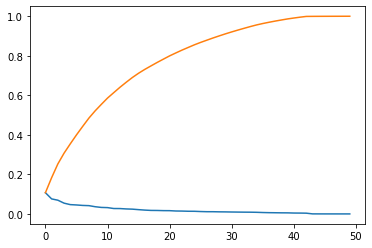

In [57]:
import matplotlib.pyplot as plt
plt.plot(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))


There isn't really a strong knee

In [66]:
#try a random word

word = 'cookie'
vect = glove_vectors.wv[word]
vect = vect.reshape(1, -1)
clf.predict(vect)

array([0], dtype=int64)

In [67]:
clf.score(X_train, y_train)

0.8453237410071942

## Now do something with test data. 

Since the test data are phrases not single words, need to do some preprocessing to:
- remove punctuation
- remove stop words (common english words that have little meaning, such as the, it, has, etc.)  
- lower case
- break into single words

In [60]:
# now do something with test data
import nltk
nltk.download()


showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [86]:
from nltk.corpus import stopwords
stpwords = list(stopwords.words('english'))
stpwords.sort()
stpwords.remove('in')
stpwords.remove('out')
stpwords

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'over',
 'own',
 're',
 's',
 'sam

In [87]:
def nlpCleanup(df, columnName):
    df[columnName] = df[columnName].str.replace('\d+', '',regex=True) # for digits
    df[columnName] = df[columnName].str.replace('[^\w\s]', '',regex=True) # for punctuation 
    return df

In [88]:
stopWords = pd.DataFrame(stpwords, columns=["stopwords"])
stopWords = nlpCleanup(stopWords, columnName = "stopwords")
stopWords = stopWords['stopwords'].unique()
stopWords

array(['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all',
       'am', 'an', 'and', 'any', 'are', 'aren', 'arent', 'as', 'at', 'be',
       'because', 'been', 'before', 'being', 'below', 'between', 'both',
       'but', 'by', 'can', 'couldn', 'couldnt', 'd', 'did', 'didn',
       'didnt', 'do', 'does', 'doesn', 'doesnt', 'doing', 'don', 'dont',
       'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had',
       'hadn', 'hadnt', 'has', 'hasn', 'hasnt', 'have', 'haven', 'havent',
       'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself',
       'his', 'how', 'i', 'if', 'into', 'is', 'isn', 'isnt', 'it', 'its',
       'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', 'mightnt',
       'more', 'most', 'mustn', 'mustnt', 'my', 'myself', 'needn',
       'neednt', 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on',
       'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'over',
       'own', 're', 's', 'same', 'shan', 'shant', 'she', 'shes'

In [89]:
test = nlpCleanup(test, columnName='daily_activities')
test

,daily_activities,risk_score
0,wake,0
1,have breakfast,0
2,brush your teeth,0
3,take shower,0
4,take bath,0
5,get dressed,0
6,school,2
7,study English,0
8,have lunch with others,2
9,wash the dishes,0


In [106]:
test['labels'] = np.where(test.risk_score==0,0,1)
# break into features and labels
X_test = test.daily_activities
#convert to binary classification
y_test = test.labels

In [96]:
# turn phrases into lists of single words and remove stop words
X_test_clean = []
for phrase in X_test:
    subset =[]
    words = phrase.split(' ')
    for word in words:
        if word not in stopWords and len(word)>0:
            subset.append(word.lower())
    X_test_clean.append(subset)
            

In [97]:
X_test_clean

[['wake'],
 ['breakfast'],
 ['brush', 'teeth'],
 ['take', 'shower'],
 ['take', 'bath'],
 ['get', 'dressed'],
 ['school'],
 ['study', 'english'],
 ['lunch', 'others'],
 ['wash', 'dishes'],
 ['read', 'book'],
 ['homework'],
 ['cook', 'dinner'],
 ['bed'],
 ['practice', 'guitar'],
 ['play', 'friends'],
 ['exercise', 'indoors'],
 ['brush', 'hair'],
 ['shopping'],
 ['walk'],
 ['take', 'out', 'trash'],
 ['clean', 'house'],
 ['read', 'newspaper'],
 ['surf', 'internet'],
 ['water', 'plants'],
 ['watch', 'alone'],
 ['relax'],
 ['listen', 'music'],
 ['laundry'],
 ['iron', 'clothes'],
 ['feed', 'dog'],
 ['walk', 'dog'],
 ['take', 'taxi'],
 ['out', 'eat'],
 ['mall'],
 ['watch', 'friends']]

In [100]:
y_pred = []
for words in X_test_clean:
    preds = []
    for word in words:
        vect = glove_vectors.wv[word]
        vect = vect.reshape(1, -1)
        pred = clf.predict(vect)
        preds.append(pred)
    avg = np.average(preds)
    if avg > 0.5:
        score=1
    else:
        score=0
    y_pred.append(score)
    
#note:  this is rediculously slow for a small test set... gotta work on that
        

In [104]:
# now for some metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

print("accuracy_score", accuracy_score(y_test, y_pred))
print("f1_score", f1_score(y_test, y_pred))
print("precision_score", precision_score(y_test, y_pred))
print("recall_score", recall_score(y_test, y_pred)) 


accuracy_score 0.6944444444444444
f1_score 0.5925925925925926
precision_score 0.4444444444444444
recall_score 0.8888888888888888


In [105]:
# let's look at the results
test['rfcPred'] = y_pred

In [107]:
test[test['rfcPred'] == test['labels']]

,daily_activities,risk_score,rfcPred,labels
2,brush your teeth,0,0,0
4,take bath,0,0,0
6,school,2,1,1
7,study English,0,0,0
8,have lunch with others,2,1,1
9,wash the dishes,0,0,0
10,read book,0,0,0
11,your homework,0,0,0
12,cook dinner,0,0,0
15,play with friends,2,1,1


In [108]:
test[test['rfcPred'] != test['labels']]

,daily_activities,risk_score,rfcPred,labels
0,wake,0,1,0
1,have breakfast,0,1,0
3,take shower,0,1,0
5,get dressed,0,1,0
13,bed,0,1,0
14,practice the guitar,0,1,0
19,for walk,0,1,0
20,take out the trash,0,1,0
25,watch alone,0,1,0
26,relax,0,1,0
